# All the President's Moods

During his tenure as US President, Donald Trump maintained a steady presence on Twitter. Since the words of the politicians tend to affect the behavior of other people, including markets, there is a sizable literature quantifying the effect of politician speeches on market behavior in the aggregate. 

Unllke other politicians, Trump's tweets were both impassioned and plentiful. This means Twitter can give a large volume of reactions to work with that have a distribution of "sentiment."

In this assignment:
1. (2 points) Load a json file of all the president's tweets from August 30 to November 5th. After loading them, put the following information into a dataframe:
    - The full text of the Tweet. (string)
    - Any users mentioned in the Tweet. (string)
    - The timestamp. (datetime)
    - The date (YYYY-MM-DD) of the Tweet. (date)
    - Retweets (numeric)
    - Favorites (numeric)
    - Whether the Tweet was censored, meaning zero retweets (binary/boolean).
    
   __Hint: list comprehensions can be your best friend!__
   
2. (2 points) Create a "clean_text" column by doing the following to "full_text":
    - removing links, which are strings that start with "http"
    - removing hashtags, which are strings that start with "#"
    - removing mentions, which are strings that start with "@"
    - converting text to lower case.
    - removing punctuation.
    
   Now report:
    - The top 10 most common words (omitting stop words).
    - The top 5 Twitter accounts that are mentioned.
    - The top 5 most liked ("favorited") tweets.
    - The top 5 hashtags (hint: use a regular expression).
3. (4 points) Graph the daily volme of tweets over time, while annotating any major events.
4. (6 points) Run the tweets through sentiment analysis, and report:
    - The 20 most "negative" and "positive" words.
    - A graph of the sentiment over time.
    
5. (6 points) Trump and the Stock Market
    - Read in the time series dataset of S&P 500 closing, daily prices. Then merge this data to Trump's daily sentiment scores. __Graph both of them (EXTRA CREDIT GRAPH)__, calculate their correlation, and interpret what you see.

    - Since Trump often comments on the stock market but the stock market may also react to his tweets, it is not clear how the causal relationship should work. Describe in detail how you would answer the question: "Did President Trump's tweet sentiment influence the stock market?" Specifically describe:
        - The data you would need in addition to these data sources.
        - The way you would read in the data and manipulate it.
        - The sort of analysis or statistics you would calculate to answer the question.

In [38]:
import pandas as pd
import json 
import matplotlib.pyplot as plt
import matplotlib
import re
import string
from nltk.corpus import stopwords
import regex
import nltk
from datetime import timedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## 1. Read Tweets

Reading Trump Tweets

In json format:

In [39]:
with open('../../Trump_tweets.json') as f:
    tweets = json.load(f)

In [40]:
df = pd.DataFrame()

df['full_text'] = [x['full_text'] for x in tweets]
df['user_mentions'] = [[ x['screen_name'] for x in y['entities']['user_mentions'] ] for y in tweets]
df['time_stamp'] = [x['created_at'] for x in tweets]
df['time_stamp'] = pd.to_datetime(df['time_stamp']) - timedelta(hours=6)
df['RTs'] = [x['retweet_count'] for x in tweets]
df['favs'] = [x['favorite_count'] for x in tweets]

df['date'] = df.time_stamp.apply(lambda x:  str(x)[:10])
df['date'] = pd.to_datetime(df.date)

df['censored'] = df['RTs']==0

To drop duplicates, I'll take the one with the most favorites.

In [41]:
df = df.sort_values(by=['time_stamp','full_text',"favs"])

df = df.groupby(['time_stamp','full_text']).last().reset_index()

## 2. Word Counts

### 2.1 Top 10 Words
#### Remove Links and User Tags

In [64]:
import re

find_links = re.compile(r'http\S+')
find_users = re.compile(r'@\w+')
find_hashtags = re.compile(r'#\w+')

df['text_nolink'] = [find_links.sub("",x) for x in df['full_text']]
df['text_nolink'] = [find_users.sub("",x) for x in df['text_nolink']]
df['text_nolink'] = [find_hashtags.sub("",x) for x in df['text_nolink']]

#### Remove punctuation and lowercase

In [43]:
import string
string.punctuation

# This maketrans function can be used to remove a list of characters from a string.
remv_punc = str.maketrans('','',string.punctuation + '“' +"‘"+'”')

df['text_lower'] =  df['text_nolink'].str.lower().str.replace("\n","")

df['text_clean'] = df.text_lower.str.translate(remv_punc)

#### Split into words

In [44]:
from nltk.corpus import stopwords

sw_list = stopwords.words('english') + ['amp',''," "]

df['words'] = [x.split(" ") for x in df['text_clean']]

#### Take out Stop Words

In [45]:
df['words'] = [list(set(x) - set(sw_list)) for x in df['words']]

#### Get the words counts

Slow way:

In [46]:
series_list = [pd.Series(x).value_counts() for x in df['words']]
word_df = pd.concat(series_list,axis=1).fillna(0).T

<ipython-input-46-f3c46b446902>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series_list = [pd.Series(x).value_counts() for x in df['words']]


In [47]:
word_df.sum().sort_values(ascending=False).head(10)

great      249.0
biden      240.0
vote       188.0
thank      185.0
joe        180.0
people     122.0
big         98.0
trump       96.0
america     92.0
get         89.0
dtype: float64

Fast way:

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

In [49]:
vct = CountVectorizer(stop_words="english")

X = vct.fit_transform(list(df['text_clean']))

word_counts = pd.DataFrame(X.sum(axis=0))
word_counts.columns = vct.get_feature_names()
word_counts = word_counts.T

word_counts = word_counts[0].sort_values(ascending=False)
word_counts.head(10)

biden      319
great      264
vote       233
amp        218
joe        215
thank      186
people     133
just       120
america    111
big        108
Name: 0, dtype: int64

In [50]:
words_ix = list(word_counts.index)

words_ix.remove("amp")

word_counts = word_counts[words_ix]

In [51]:
word_counts.head(10)

biden      319
great      264
vote       233
joe        215
thank      186
people     133
just       120
america    111
big        108
trump      106
Name: 0, dtype: int64

#### Bar Chart

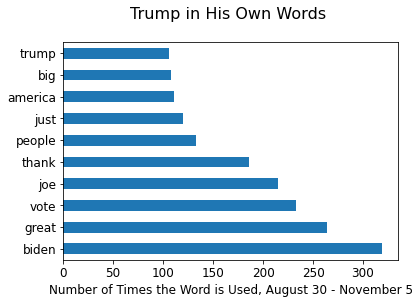

In [52]:
font = {'family' : 'normal',
        'weight': "normal",
        'size'   : 12}

matplotlib.rc('font', **font)


word_counts.head(10).plot(kind='barh',figsize=(6,4))

plt.xlabel("Number of Times the Word is Used, August 30 - November 5")

plt.title("Trump in His Own Words \n",fontsize=16)
plt.savefig("trump_words.png",dpi=250,bbox_inches="tight")

### 2.2 Mentioned Accounts

Using the Twitter entry:

In [85]:
mention_lists = [pd.Series(x).value_counts() for x in df['user_mentions']]

mention_counts = pd.concat(mention_lists,axis=1).T.fillna(0)

top5_mentions = list(mention_counts.sum().sort_values(ascending=False).head(5).index)

top5_mentions

<ipython-input-85-411a56e6063d>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mention_lists = [pd.Series(x).value_counts() for x in df['user_mentions']]


['BreitbartNews', 'FoxNews', 'OANN', 'CNN', 'cspan']

Using regex:

In [84]:
mention_lists = [find_users.findall(x) for x in df['full_text'] if len(find_users.findall(x))>0 ]
all_mentions = pd.Series(mention_lists).sum()
pd.Series(all_mentions).value_counts().head()

@BreitbartNews    49
@FoxNews          31
@OANN             10
@cspan             8
@CNN               8
dtype: int64

Text(0.5, 0, 'Number of Times a User is Mentioned, August 30 - November 5')

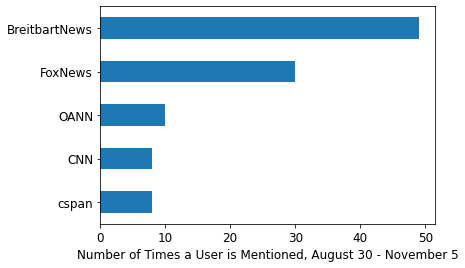

In [12]:
mention_counts.sum().sort_values(ascending=True).tail(5).plot(kind='barh')
plt.xlabel("Number of Times a User is Mentioned, August 30 - November 5")


Now, we could also look at cumulative mentions over time.

In [87]:
mention_counts[top5_mentions].reset_index(drop=True)

,BreitbartNews,FoxNews,OANN,CNN,cspan
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
1784,1.0,0.0,0.0,0.0,0.0
1785,0.0,0.0,0.0,0.0,0.0
1786,0.0,0.0,0.0,0.0,0.0
1787,1.0,0.0,0.0,0.0,0.0


In [88]:
df = df.reset_index(drop=True).join(mention_counts[top5_mentions].reset_index(drop=True))

Text(0.5, 1.0, 'Cumulative Mentions')

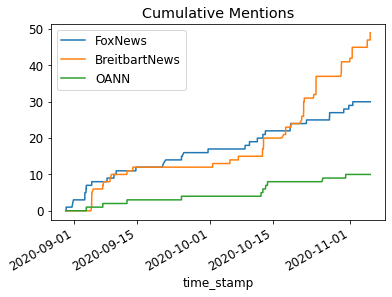

In [89]:
df.set_index("time_stamp")['FoxNews'].sort_index().cumsum().plot()
df.set_index("time_stamp")['BreitbartNews'].sort_index().cumsum().plot()
df.set_index("time_stamp")['OANN'].sort_index().cumsum().plot()
plt.legend()
plt.title("Cumulative Mentions")

Trump switched from citing Fox News to citing Breitbart when Fox called the election for Joe Biden.

### 2.3 Most Favorited

In [95]:
favor_5 = df.sort_values("favs",ascending=False).head()[['time_stamp','full_text','favs']]

favor_5.columns = ['Time Stamp',"Tweet",'Number of Favorites']

In [96]:
pd.set_option('display.max_colwidth', None)
favor_5[['Tweet','Time Stamp',"Number of Favorites"]]

,Tweet,Time Stamp,Number of Favorites
773,"Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We will get through this TOGETHER!",2020-10-01 22:54:06+00:00,1858018
775,"Going welI, I think! Thank you to all. LOVE!!!",2020-10-02 21:31:34+00:00,1202110
1770,WE ARE LOOKING REALLY GOOD ALL OVER THE COUNTRY. THANK YOU!,2020-11-03 17:15:55+00:00,957283
1771,I will be making a statement tonight. A big WIN!,2020-11-03 23:45:53+00:00,925883
1763,This Tweet from @realDonaldTrump has been withheld in response to a report from the copyright holder. Learn more.,2020-11-03 01:57:08+00:00,905506


### 2.4 Most Used Hashtags

Find hashtags using the regular expression: "#\w+"

<ipython-input-97-1e72766fcd6a>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hashtag_series = [pd.Series(x).value_counts() for x in df['hashtag_list']]


Text(0.5, 0, 'Number of Times a Hashtag is Used, August 30 - November 5')

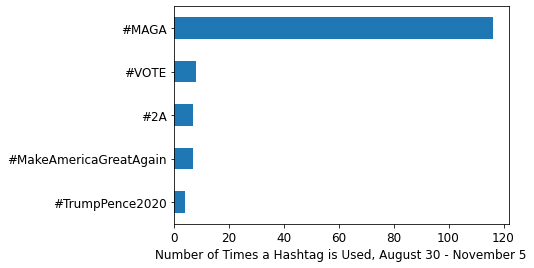

In [97]:
import regex
hashtag = regex.compile(r'#\w+')
df['hashtag_list'] = df['full_text'].apply(lambda x: hashtag.findall(x))

hashtag_series = [pd.Series(x).value_counts() for x in df['hashtag_list']]

hashtag_df = pd.concat(hashtag_series,axis=1).T.fillna(0)

hashtag_df.sum().sort_values().tail(5).plot(kind='barh')
plt.xlabel("Number of Times a Hashtag is Used, August 30 - November 5")


## 3. Tweet Volume

In [101]:
top20_dates = df.date.value_counts().head(20)

top20_dates

2020-11-02    69
2020-10-30    63
2020-10-12    63
2020-10-31    62
2020-10-27    61
2020-11-01    51
2020-09-08    48
2020-10-07    48
2020-10-13    46
2020-09-30    40
2020-10-24    39
2020-10-21    39
2020-09-17    39
2020-09-10    38
2020-09-14    37
2020-09-29    37
2020-10-17    36
2020-10-06    36
2020-09-09    35
2020-09-12    31
Name: date, dtype: int64

#### Some important dates:
- Sept 29th: First Presidential Debate
- Oct 15th: Planned Second Debate (which Trump refused to show up for).
- Oct 22nd: Final Debate
- Nov 3rd: Election Day

In [102]:
dates = df.date.sort_values().drop_duplicates().reset_index(drop=True)

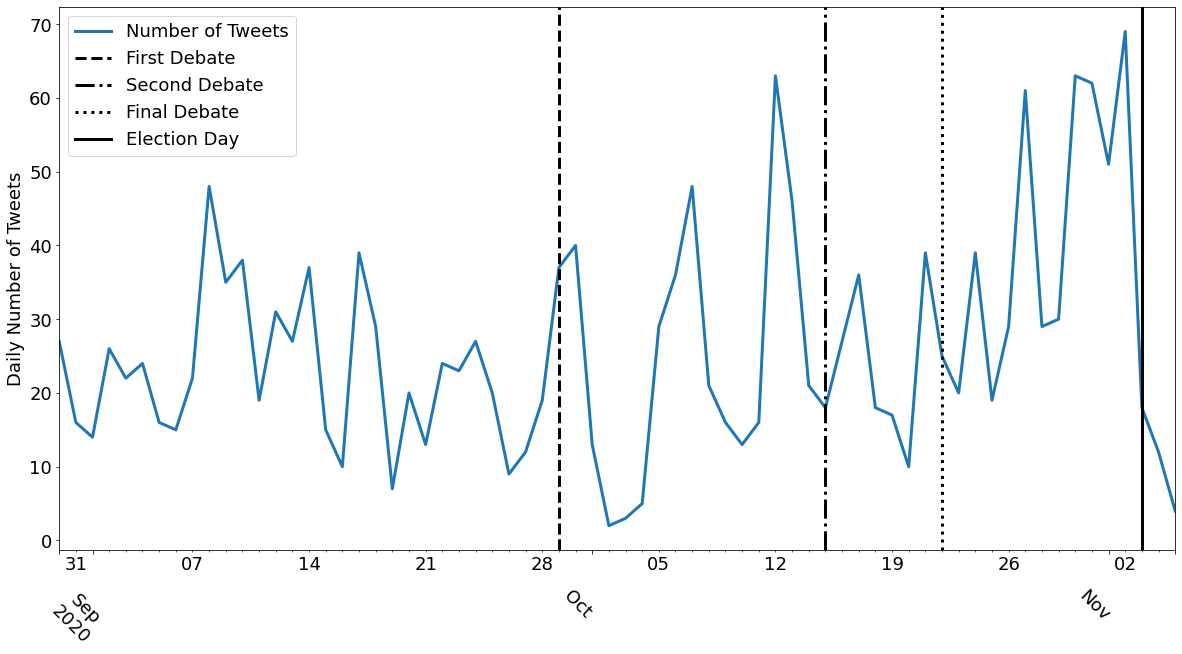

In [103]:
font = {'family' : 'normal',
        'weight': "normal",
        'size'   : 18}

matplotlib.rc('font', **font)


df.date.value_counts().sort_index().plot(label="Number of Tweets",figsize=(20,10),lw=3)
plt.xticks(rotation=-45)

plt.axvline("2020-09-29",ls="--",color="black",label="First Debate",lw=3)
plt.axvline("2020-10-15",ls="-.",color="black",label="Second Debate",lw=3)
plt.axvline("2020-10-22",ls=":",color="black",label="Final Debate",lw=3)
plt.axvline("2020-11-03",ls="-",color="black",label="Election Day",lw=3)

plt.ylabel("Daily Number of Tweets")
plt.legend(loc="upper left")

#### Top 5 words on those days

In [104]:
word_df = pd.concat([df[['date']],word_df],axis=1)

def top5_words(date):
    return list(word_df[word_df.date==date].iloc[:,1:].sum().sort_values(ascending=False).head().index)

words_on_days = pd.DataFrame([top5_words(x) for x in top20_dates.index]).T

words_on_days.index = [1,2,3,4,5]

words_on_days.columns = top20_dates.index

In [105]:
words_on_days.T

,1,2,3,4,5
2020-11-02,biden,vote,joe,pennsylvania,get
2020-10-30,biden,vote,joe,america,president
2020-10-12,vote,joe,biden,big,sleepy
2020-10-31,complete,total,endorsement,amendment,second
2020-10-27,great,thank,vote,wisconsin,biden
2020-11-01,biden,great,joe,vote,thank
2020-09-08,great,biden,thank,money,new
2020-10-07,vote,biden,president,country,years
2020-10-13,pennsylvania,people,vote,airport,join
2020-09-30,joe,thank,sleepy,biden,left


## 4. Sentiment

In [106]:
sid = SentimentIntensityAnalyzer()

pol_scores = [sid.polarity_scores(x)['compound'] for x in df['text_clean']]

df['sentiment'] = pd.Series(pol_scores)

In [107]:
sent_ts = df.set_index("time_stamp").sort_index()

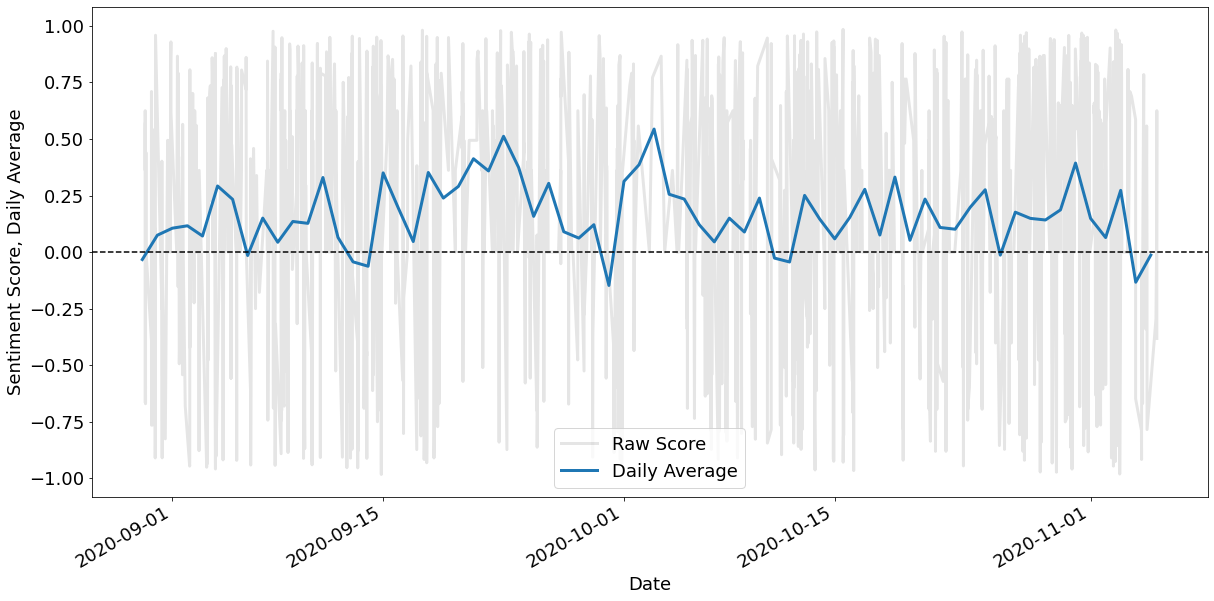

In [108]:
f,a = plt.subplots(figsize=(20,10))
sent_ts['sentiment'].plot(alpha=.1,ax=a,color="black",label="Raw Score",lw=3)
df.groupby("date")['sentiment'].mean().plot(ax=a,label="Daily Average",lw=3)

# df.groupby("date")['sentiment'].mean().plot()
plt.axhline(0,color="black",ls="--")
# plt.xticks(rotation=-45)
plt.ylabel("Sentiment Score, Daily Average")
plt.xlabel("Date")

plt.legend()

#### What do the happiest and saddest tweets look like?

In [109]:
df.set_index("time_stamp").sort_values("sentiment")[['full_text','sentiment']].head()

,full_text,sentiment
time_stamp,,
2020-09-14 21:04:33+00:00,"According to press reports, Iran may be planning an assassination, or other attack, against the United States in retaliation for the killing of terrorist leader Soleimani, which was carried out for his planning a future attack, murdering U.S. Troops, and the death &amp; suffering...",-0.9829
2020-11-02 22:25:17+00:00,"Our prayers are with the people of Vienna after yet another vile act of terrorism in Europe. These evil attacks against innocent people must stop. The U.S. stands with Austria, France, and all of Europe in the fight against terrorists, including radical Islamic terrorists.",-0.9810
2020-10-29 17:34:47+00:00,"Failed RINO former Governor Rick Snyder of Michigan was a disaster with respect to the Flint Water CATASTROPHE, and a very bad Governor overall. He hurt so many people with his gross incompetence. He reminds me of Sleepy Joe!",-0.9729
2020-10-28 15:42:48+00:00,"Who is Miles Taylor? Said he was “anonymous”, but I don’t know him - never even heard of him. Just another @nytimes SCAM - he worked in conjunction with them. Also worked for Big Tech’s @Google. Now works for Fake News @CNN. They should fire, shame, and punish everybody....",-0.9721
2020-10-16 06:15:38+00:00,"Steve Scully of @cspan had a very bad week. When his name was announced, I said he would not be appropriate because of conflicts. I was right! Then he said he was hacked, he wasn’t. I was right again! But his biggest mistake was “confiding” in a lowlife loser like the Mooch. Sad!",-0.9659


The top two saddest tweets are about terrorism and assasination, the rest have an agressive tone speaking about various people.

In [110]:
df.set_index("time_stamp").sort_values("sentiment",ascending=False)[['full_text','sentiment']].head()

,full_text,sentiment
time_stamp,,
2020-10-15 13:20:21+00:00,"It was great to be back in North Carolina with thousands of loyal, hardworking American Patriots! This election is a simple choice: If Biden Wins, China Wins. When WE Win, YOU WIN, North Carolina WINS, and America WINS! https://t.co/jWYVYZdT3E",0.9843
2020-11-02 16:12:45+00:00,"As Christians throughout this great Country celebrate All Souls Day, let’s remember those who went before us and built this great nation. May their legacy inspire us as we keep our nation what it has always been: blessed and great!",0.9816
2020-09-17 14:38:16+00:00,"I would like to extend best wishes and a very happy 70th birthday to the Prime Minister of India, @narendramodi. Many happy returns to a GREAT LEADER and loyal friend! https://t.co/CWlVkHk16X",0.9806
2020-09-22 19:20:26+00:00,"I was honored to be back in the Commonwealth of Pennsylvania with thousands of loyal, hardworking American Patriots. This election is a choice between Pennsylvania &amp; China. If Biden wins, China wins. When we win, Pennsylvania Wins, and AMERICA WINS! #MAGA https://t.co/GTSNoUDpHf",0.9788
2020-09-07 16:30:32+00:00,"Congratulations to Dustin Johnson @DJohnsonPGA on not only a great winning streak and golf season, but on capping it off with a fantastic @PGA Tour Championship and becoming the 2020 FEDEXCUP Champion. Dustin is a true WINNER in so many ways!",0.9762


Notice the happy tweets have things like "happy," "blessed," "winner," and so forth.

### "Happiest and Saddest Words"

#### Words that correlate with sentiment.
correlate word counts with sentiment score.

In [111]:
sent_words_corr = word_df.join(df[['sentiment']]).corr()['sentiment']

###### Bad words

In [112]:
sent_words_corr.sort_values().head(20)

fake         -0.224138
bad          -0.170966
biden        -0.160597
disaster     -0.158893
biden’s      -0.148747
news         -0.137332
death        -0.136131
wrong        -0.135556
scam         -0.133960
failed       -0.130606
democrat     -0.128382
swine        -0.127603
joe          -0.125995
flu          -0.125565
pathetic     -0.125120
ban          -0.120925
loser        -0.119895
terrorists   -0.117716
ballots      -0.114352
rigged       -0.114247
Name: sentiment, dtype: float64

Besides the typical negative words, "Biden," "fake," and "news," "swine," and "ballots" are notable exceptions. While these are not necessarily bad words by themselves, what this shows is the Trump combines these words with other negative words.

###### Good Words

In [32]:
sent_words_corr.sort_values(ascending=False).head(21)

sentiment      1.000000
great          0.388239
thank          0.237245
endorsement    0.228670
complete       0.199770
america        0.188469
amendment      0.178846
strong         0.177361
second         0.167331
win            0.166521
congressman    0.155843
honor          0.146144
total          0.144664
wins           0.139711
best           0.128158
brave          0.126025
make           0.121588
incredible     0.117142
vets           0.115542
protect        0.109578
state          0.109405
Name: sentiment, dtype: float64

Most of these are good words already, but notice "congressman," "vets," "amendment" (referring to second amendment), and "America" as words that Trump includes in his most positive tweets.

## 5. Trump and the Stock Market
### Part 1

In [114]:
sp500 = pd.read_csv("../Data/Text/SandP500.csv")

sp500['date'] = pd.to_datetime(sp500['DATE'])
df = df.merge(sp500,how='left',on='date',indicator='i')

df['SP500'] =pd.to_numeric(df['SP500'],errors='coerce')

price_and_sent = df.groupby("date")[['sentiment','SP500']].mean()

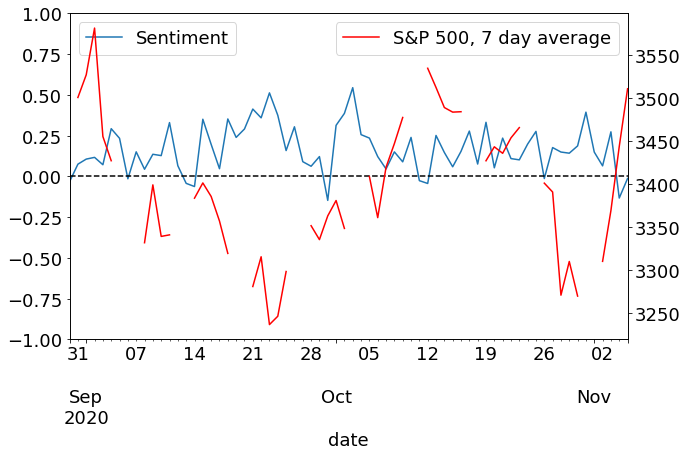

In [119]:
f,a = plt.subplots(figsize=(10,6))

price_and_sent['sentiment'].plot(ax=a,label="Sentiment")
plt.axhline(0,color="black",ls="--")
plt.legend(loc='upper left')
a.set_ylim(-1,1)
a2 = a.twinx()

# price_and_sent['SP500'].rolling(7,min_periods=1).mean().plot(ax=a2,color='red',label="S&P 500, 7 day average")
price_and_sent['SP500'].plot(ax=a2,color='red',label="S&P 500, 7 day average")

plt.legend()

In [35]:
price_and_sent.corr()

,sentiment,SP500
sentiment,1.000000,-0.415257
SP500,-0.415257,1.000000


There is a somehwhat strong correlation between Trump's sentiment and S&P 500, but it is __negative__: the more positive Trump's Tweets are the lower stock prices are. A couple of possibilities:
- Spurious correlation ([for example](https://www.tylervigen.com/spurious-correlations)).
- Omitted variable bias: there is something that drives Trump's sentiment but also drives stock prices, which makes the relationship look stronger than it actually is. Certain events may be to blame more than Trump or the stock market; for example, certain events could be affecting both in opposite ways. This means it is __not a causal relationship__.
- Trump interprets things positively that the market inteprets as bullish. For example, many positive Trump tweets were congratulating the victories of certain politicians or policies that market may not welcome. This would __not be a causal relationship__. 
- Trump's comments during this period promoted distrust in institutions (such as mail-in voting) and were thought of as destabilizing, which the market may have interpreted as a bad signal for the economy. This would also be a __causal relationship__.

Note that the sizable jump in the stock market following November 3 indicate that Trump leaving office did appear to affect markets, since that was the most major event happening at the time.

### Part 2
#### Data:
You would want any data that would be specific to predicting stock prices, as well as information about policies or other elections that Trump would tweet about. A first step to finding this would be to search Trump tweets for ideas about what things make his radar that would also be important to aggregate stock prices. You could create dummy variables when he mentions certain accounts, for example. It would also be a good idea to make lags of the sentiment and variables, since likely there is autocorrelation. Other stock indices or macroeconomic variables would be a good idea.

Daily closing prices also probably miss some important variation. Since our tweets are at the timestamp level, you could find realtime stock price changes instead of daily prices.

Finally, you would also want indicator variables for major events.

#### Preparation:
Creating lags of the variables would be fairly easy using the __shift()__ function for pandas Series objects. Other macroeconomic variables are widely available.

To make variables reflecting what Trump mentions, you could use the "mentions" column or else you could try and use the bag-of-words approach by simply counting the number of times certain accounts or hashtags appear.

Notice here that I used average sentiment; another option is to look at the standard deviation of his sentiment on that day. Perhaps Tweet volatility is a more significant variable than just the average.

#### Analysis:
Understanding how these variables act as a system might lead to a Vector Autoregression (VAR) approach whereby lags of all of the variables are included in a regression model. It is plausible that there is a lag between when Trump tweets something and the market would react. To get at this, it would be a good idea to use stock prices at the most fine time scale available. It could be the case that the market reaction happens within a day, and daily prices won't tell you this.